## What are we going to cover
* get  a vision dataset from torchvision.datasets
* architecture of a CNN with PyTorch
* An end to end multi-class image classification problem
* steps in modelling with CNNs in pytorch
    * Creating a CNN model with PyTorch
    * Picking a Loss and optimizer
    * Training a model a model
    * Evaluating a model

## Computer Vision Libraries
* `torchvision` -base domain library for  computer vision
* `torchvision.datasets` - get datasets and data loading function for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data(images)  to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch (creates custom data with your own datasets)
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
#import libraries
import torch
from torch import nn


#import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # `ToTensor` --> Convert a PIL image or numpy.ndarray to tensor


#import matplotlib
import matplotlib.pyplot as plt


#Check versions
print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.0


## Getting a Dataset
The dataset we are going to use is -- **`FashionMNIST`** from torchvison.datasets-


In [2]:
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root = "data", #where to download data to
    train = True, # do we want the training dataset? if train = False it will upload the test dataset
    download = True, #do we want to download the data? (Yes/No)
    transform = ToTensor(), #how do we want to transform the data
    # `transform` convert the pil image or np.ndarray into pytorch, it converts the image (H*W*C) in the range [0,255] to 
    # a torch.FloatTensor of shape (C*W*H) in the range [0.0,1]
    target_transform =None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

In [3]:
class_names = train_data.classes

## Visualizing our data

Image shape: torch.Size([1, 28, 28])


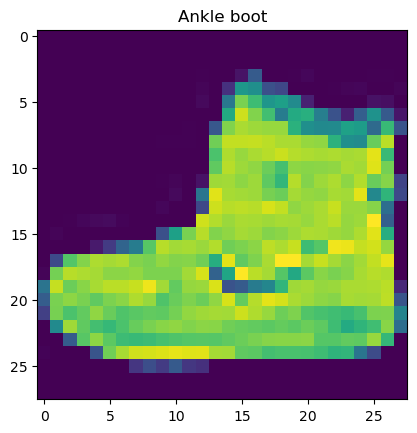

In [4]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.title(class_names[label])
plt.imshow(image.squeeze())

(-0.5, 27.5, 27.5, -0.5)

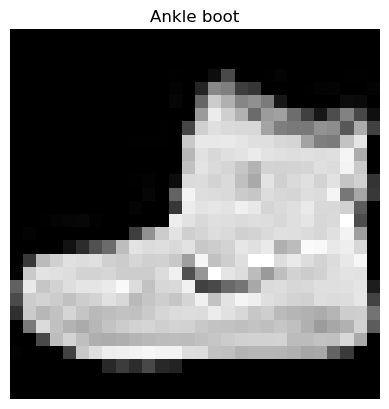

In [5]:
#gray mapping images
plt.imshow(image.squeeze(),cmap = 'gray')
plt.title(class_names[label])
plt.axis("off")

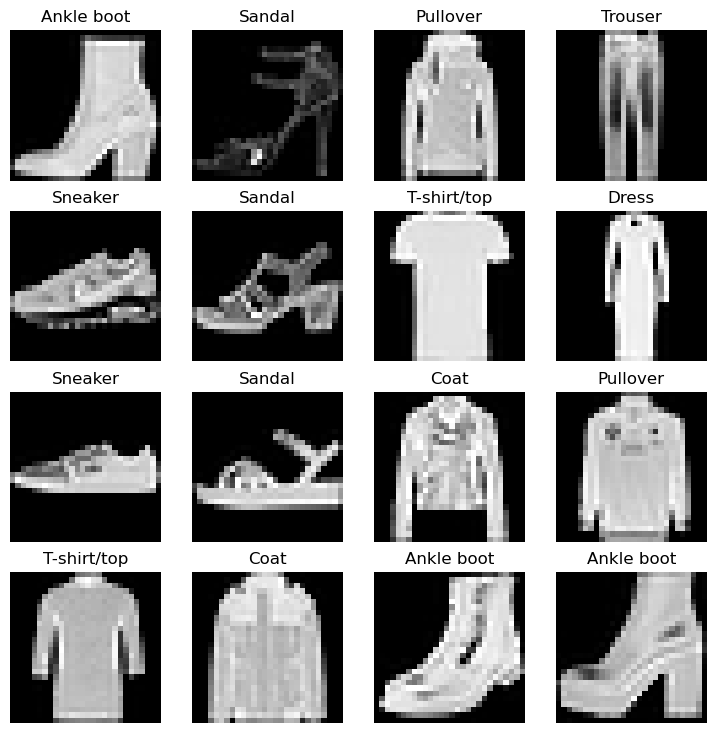

In [6]:
#torch.manual_seed(42)

fig = plt.figure(figsize = (9,9))
rows ,cols = 4,4
for i in range(1, rows*cols +1): # i is for subplotting
    random_idx = torch.randint(0,len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(),cmap = 'gray')
    plt.title(class_names[label])
    plt.axis(False);
    
    

In [7]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

# `Prepare DataLoader` (Train and Test Data)

Right now, our data is in the from of PyTorch Datasets

DataLoader turns our dataset into a PyTorch iterable

More specifically, we want to turn our data into batches(mini batches)



In [8]:
from torch.utils.data.dataloader import DataLoader

#batch size
BATCH_SIZE = 32

#turn datasets into iterable(batches)
train_dataloader = DataLoader(dataset = train_data,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16e740550>,
 <torch.utils.data.dataloader.DataLoader at 0x100983c90>)

In [9]:
len(train_dataloader)

1875

In [10]:
#check out the status 

print(f" DataLoaders: {train_dataloader,test_dataloader}")
print(f" Length of train dataloader : {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f" Length of test dataloader : {len(test_dataloader)} batches of {BATCH_SIZE}")

 DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x16e740550>, <torch.utils.data.dataloader.DataLoader object at 0x100983c90>)
 Length of train dataloader : 1875 batches of 32
 Length of test dataloader : 313 batches of 32


In [11]:
#check out what's inside the train dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape #train_labels_batch represents the associted number of target values inside of a batch

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

So one single batch has 32 images, where shape of each sample is (1,28,28)--> color_channel,height,weight 


The representation of 4th image 


(-0.5, 27.5, 27.5, -0.5)

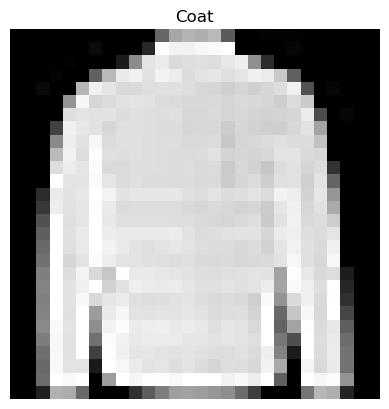

In [12]:
#show a sample of a particular batch

random_idx = torch.randint(0,len(train_features_batch),size =[1]).item()
image, label = train_features_batch[random_idx],train_labels_batch[random_idx]

#got the image and the associated label
print(f"The representation of {random_idx}th image ")
plt.imshow(image.squeeze(),cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)


# Baseline `Model` with two Linear Layers

when starting to build a series of ML modelling experiments, it's best practice to start with a baseline model. 

A baseline model is a simple model you willl try and improve upon with subsequent models/experiments. 

In other words: Start simply and add complexity when necessary

In [13]:
# Create a flatten layer
flatten_model = nn.Flatten()

#get a single sample
x = train_features_batch[0]

#flatten the sample
output = flatten_model(x) # performs the forward pass

#print out what happened
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


## Model_00

In [14]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int, 
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                     out_features= hidden_units),
            nn.Linear(in_features = hidden_units,
                     out_features = output_shape)
        )


    def forward(self, x):
        return self.layer_stack(x)
    

In [15]:
#device agnostic code
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [16]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape=784, # this is 28*28
    hidden_units = 10, 
    output_shape = len(class_names)
)

model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

# Loss Function and Optimizer
* `Loss Function` - nn.CrossEntropyLoss()
*  `optimizer` - torch.optim.SGD
*  `Evaluation Matrix` - Accuracy

In [17]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                           lr = 0.01)

from torchmetrics import Accuracy
acc_fn = Accuracy(task = 'Multiclass',
                  num_classes = 10
                 ).to(device)
acc_fn

MulticlassAccuracy()

In [18]:
#download the py file
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download ....")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
        print("download Complete")
        

helper_functions.py already exists, skipping download ....


In [19]:
from helper_functions import accuracy_fn

In [20]:
accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

## Creating a funtion to time our experiments

Machine learning is very experimental

2 of the main things you'll often want to track are:
1. Model's performance
2. How fast it runs

In [21]:
from timeit import default_timer as timer
def print_train_time(start: float,
                    end: float,
                    device: torch.device = None):

    """Prints difference between start and end time. """
    total_time = end-start
    print(f"Train time on {device}: {total_time} seconds")
    return total_time

In [22]:
start_time = timer()
#some code
end_time = timer()
total_time = print_train_time(start_time,end_time,device = device)

Train time on mps: 1.0957999620586634e-05 seconds


## Building Training and Testing Loop
Highlight that the `optimizer` will update a model's `parameters` once `per batch` rather than once per epoch........

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through test batches, perform testing steps , calculate the test loss per batch
4. Print out what's happening
5. Time it all(for run)

In [23]:
model_0.to('cpu')
from tqdm.auto import tqdm
#set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

#set the number of epochs
epochs = 3

#create e training and test loop

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n......")

    #Training
    train_loss = 0 #instantiate the training loss

    #calculate the training loss per batch

    # Per epoch calculate the loss of the total train datasets;

    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader): # X --> image(features), y--> target label
        model_0.train()

        # 1. forward pass
        y_pred = model_0(X) # X represents a full batch of image in our train dataloader

        # 2. Loss calculation
        loss = loss_fn(y_pred, y) #loss --> loss per batch
        train_loss +=loss # Accumulate train loss # train_loss --> Total loss 

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        #we are updating our model's parameters once per batch rather than waiting for it to see the whole dataset with every batch
 

        # Print out what's happening
        
        if batch %400 == 0:
            print(f" Looked at {batch * len(X)}/ {len(train_dataloader.dataset)} samples.")
        

    # Divide total train loss by length of train dataloader
    train_loss /=len(train_dataloader)



    ### Testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

           # 1. Forward pass
            test_pred = model_0(X_test) # X_test batch in dataloader

            # 2. Calculate the loss accumulatively
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim =1))
        
        # Calculate the test loss avg per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)


    # Print out what's happening
    print(f" \nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_gpu,
                                           end = train_time_end_on_cpu,
                                           device = str(next(model_0.parameters()).device))

            
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
......
 Looked at 0/ 60000 samples.
 Looked at 12800/ 60000 samples.
 Looked at 25600/ 60000 samples.
 Looked at 38400/ 60000 samples.
 Looked at 51200/ 60000 samples.
 
Train loss: 0.9096 | Test loss: 0.6290 | Test acc: 78.6342
Epoch: 1
......
 Looked at 0/ 60000 samples.
 Looked at 12800/ 60000 samples.
 Looked at 25600/ 60000 samples.
 Looked at 38400/ 60000 samples.
 Looked at 51200/ 60000 samples.
 
Train loss: 0.5573 | Test loss: 0.5441 | Test acc: 81.1302
Epoch: 2
......
 Looked at 0/ 60000 samples.
 Looked at 12800/ 60000 samples.
 Looked at 25600/ 60000 samples.
 Looked at 38400/ 60000 samples.
 Looked at 51200/ 60000 samples.
 
Train loss: 0.5027 | Test loss: 0.5137 | Test acc: 81.9988
Train time on cpu: 5.543765583017375 seconds


# Make predictions and get Model 0 results

In [24]:
def eval_mode(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn):
    """Returns a dictionary containing the results of model predicting the data loader"""
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                              y_pred = y_pred.argmax(dim=1))

        #scale loss and acc to find the average loss/acc per batch
    loss=loss /len(data_loader)
    acc  = acc/ len(data_loader)


    return {"model_name": model.__class__.__name__,
           "model_loss": loss.item(),
           "model_acc":acc}
            
    #calculate model_0 results on test dataset
model_0_results  = eval_mode(model= model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

model_0_results
    

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5136752128601074,
 'model_acc': 81.9988019169329}

# A comparatively complex Model (Model_01)

In [25]:
# model 01
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_unit: int,
                 output_size: int):
        super().__init__()
    
        self.model_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_size,
                      out_features = hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features = hidden_unit,
                     out_features = output_size)
        )


    def forward(self, x):
        return self.model_stack(x)

model_01 = FashionMNISTModelV1(input_size = 784,
                              hidden_unit=50,
                              output_size=len(class_names)).to(device)

## Setup Loss, Optimizer, and Evaluation Matrix 

In [26]:
# Loss Function
loss_fn  = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_01.parameters(),
                            lr = 0.01)

# Evaluation Matrix
from helper_functions import accuracy_fn

# Training & Testing Loop

In [27]:
#turning our training loop into a functio
def training_loop(
                 model: torch.nn.Module,
                 train_data: torch.utils.data.DataLoader,#unit of train_data is batch
                 Loss: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 accuracy_fn,
                 device = device):

    
    model.train()

    train_loss,train_acc = 0,0
    #segment the batch
    
    for batch,(X_train,y_train) in enumerate(train_data):
        X_train,y_train = X_train.to(device),y_train.to(device)
        # 1. Forward pass
        y_pred = model(X_train)

        # 2. Loss Calculation
        loss = Loss(y_pred,y_train)

        train_loss +=loss

        acc = accuracy_fn(y_train,
                          y_pred.argmax(dim =1))
        train_acc +=acc
        # 3. Set the gradient zero
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Optimizing step
        optimizer.step()


    train_loss /=len(train_data)
    train_acc /=len(train_data)

    print(f"Train loss: {train_loss:.5f} | Train accuracy {train_acc:.5f}")
        
            

In [28]:
# Testing Loop

def testing_loop(model: torch.nn.Module,
                test_data: torch.utils.data.DataLoader,
                Loss: torch.nn.Module,
                accuracy_fn,
                device = device):

    
    test_loss,test_acc = 0,0
    model.eval()
    
    
    
    with torch.inference_mode():
        for X_test,y_test in test_data:
            X_test,y_test = X_test.to(device),y_test.to(device)

            # 1. Forward Pass
            y_test_pred = model(X_test)

            # 2. Calculate loss
            loss = Loss(y_test_pred, y_test)
            test_loss +=loss
            acc = accuracy_fn(y_test,
                             y_test_pred.argmax(dim = 1))
            test_acc +=acc

        avg_test_loss = test_loss/len(test_data)
        avg_acc = test_acc/len(test_data)
        print(f"Avg test Loss: {avg_test_loss:.4f} | Avg accuracy: {avg_acc:.4f}")
        

In [29]:
torch.manual_seed(42)

#measure time
from timeit import default_timer as timer

train_time_start_on_gpu = timer()

#set epochs 
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}.........")
    training_loop(model= model_01,
                  train_data=train_dataloader,
                  Loss = loss_fn,
                  accuracy_fn = accuracy_fn,
                  optimizer = optimizer
                 )
    testing_loop(model = model_01,
                test_data=test_dataloader,
                Loss = loss_fn,
                accuracy_fn= accuracy_fn
                )
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                           end = train_time_end_on_gpu,
                                           device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0.........
Train loss: 0.52297 | Train accuracy 81.36500
Avg test Loss: 0.4453 | Avg accuracy: 84.2153
Epoch: 1.........
Train loss: 0.44421 | Train accuracy 84.13167
Avg test Loss: 0.4421 | Avg accuracy: 84.2951
Epoch: 2.........
Train loss: 0.42250 | Train accuracy 84.85500
Avg test Loss: 0.4976 | Avg accuracy: 82.4481
Train time on mps: 31.716797125001904 seconds


> **Note:** Sometimes, depending on your data/hardware you might find that your model trains
faster on CPU than GPU

>
> Why is this?
>
> 1. It could be that the overhead for copying data/model to and from the GPU outweighs the
compute benefits offered by the GPU

# Get model_1 results dictionary



In [30]:
# evaluation loop
def eval_mode(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device = device):
    """Returns a dictionary containing the results of model predicting the data loader"""
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                              y_pred = y_pred.argmax(dim=1))

        #scale loss and acc to find the average loss/acc per batch
    loss=loss /len(data_loader)
    acc  = acc/ len(data_loader)


    return {"model_name": model.__class__.__name__,
           "model_loss": loss.item(),
           "model_acc":acc}
            

In [31]:
evaluation_model_1 = eval_mode(model = model_01,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [32]:
evaluation_model_1

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4975889027118683,
 'model_acc': 82.44808306709265}

## Building a Convolutional Neural Network

* CNN's are also known as ConvNets.
* CNN's are known for their capabilities to find patterns in visual data.
* More details --> see this website: https://poloclub.github.io/cnn-explainer/

In [33]:
# Create a conbolutional neural network

class FashionMNISTModelV2(nn.Module):
    '''
    Model architecture that replicates the TinyVGG
    model from CNN explainer website.
    
    '''
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):

        super().__init__()
        # Write some conv blocks(blocks are comprised of some layers)
        # Convolutional architecture contains a number of conv blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3, #kernel could be int or tupple; like (3,3)
                     stride = 1,
                     padding =1), #values we can set ourselves in out NN's are called hyperparameters
            
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                     out_channels = hidden_units,
                     kernel_size= 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3, #kernel could be int or tupple; like (3,3)
                     stride = 1,
                     padding =1), #values we can set ourselves in out NN's are called hyperparameters
            
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                     out_channels = hidden_units,
                     kernel_size= 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                     out_features=output_shape)
        )


    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)

        return x




In [34]:
torch.manual_seed(42)
model_02 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [35]:
# Create a sample image, and pass it through the model
image.shape

torch.Size([1, 28, 28])

In [36]:
sample_image = torch.randn(size = (1,28,28))

# Pass the image through the model
output = model_02(sample_image.unsqueeze(dim=0).to(device))

In [37]:
torch.manual_seed(42)

#create a batch of image
images = torch.randn(size =(32,3,64,64))

test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Test image shape: {test_image.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Test image shape: torch.Size([3, 64, 64])


In [38]:
# Create a single conv2d Layer

conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 64,
                       kernel_size=5,
                       stride =2,
                       padding =0)

# Pass the test image through the convolutional layer
output_image = conv_layer(test_image)
                       

In [39]:
print(f"Test image shape: {test_image.shape}")
print(f"Output image shape: {output_image.shape}")

Test image shape: torch.Size([3, 64, 64])
Output image shape: torch.Size([64, 30, 30])


## Manual Shape Calculation for Gray Scale Image

In [40]:
def shape_calculation(input_image: int, 
                     padding: int,
                     stride: int,
                     kernel_size: int,
                     dilation: int,
                     ):
    _,H,W = input_image.shape
    H_out = ((H+(2*padding[0])-dilation[0]*(kernel_size[0]-1)-1)/stride[0])+1
    W_out = ((W+(2*padding[1])-dilation[1]*(kernel_size[1]-1)-1)/stride[1])+1


    return H_out,W_out

In [41]:
test_image_for_shape = torch.randn(size=(1,14,14))
test_image_for_shape.shape

torch.Size([1, 14, 14])

In [42]:
new_shape = shape_calculation(test_image_for_shape,
                             padding=(1,1),
                             stride =(1,1),
                             kernel_size=(3,3),
                             dilation=(1,1))

In [43]:
new_shape

(14.0, 14.0)

In [44]:
## Setup Loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_02.parameters(),
                           lr = 0.1)

# Training and Testing Models

In [45]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Measure Time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}....")
    train = training_loop(model = model_02,
                         train_data = train_dataloader,
                         Loss = loss_fn,
                         optimizer = optimizer,
                         accuracy_fn=accuracy_fn)
    test = testing_loop(model = model_02,
                       test_data=test_dataloader,
                       Loss = loss_fn,
                       accuracy_fn = accuracy_fn)
train_time_end_model_02 = timer()
total_train_time_model_02 = print_train_time(start = train_time_start_model_2,
                                            end = train_time_end_model_02,
                                            device = device)
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0....
Train loss: 0.59367 | Train accuracy 78.50333
Avg test Loss: 0.3914 | Avg accuracy: 86.0124
Epoch: 1....
Train loss: 0.36027 | Train accuracy 86.85167
Avg test Loss: 0.3472 | Avg accuracy: 87.4601
Epoch: 2....
Train loss: 0.32369 | Train accuracy 88.32167
Avg test Loss: 0.3241 | Avg accuracy: 88.3886
Train time on mps: 40.984820625017164 seconds


In [46]:
# Get model results
model_02_results = eval_mode(model= model_02,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn
                            )

model_02_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3240518569946289,
 'model_acc': 88.38857827476038}

In [47]:
## Compare Model results and training time
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                              evaluation_model_1,
                                model_02_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.513675,81.998802
1,FashionMNISTModelV1,0.497589,82.448083
2,FashionMNISTModelV2,0.324052,88.388578


In [48]:
compare_results["training_time"] = [total_train_time_model_0,
                                   total_train_time_model_1,
                                   total_train_time_model_02]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.513675,81.998802,5.543766
1,FashionMNISTModelV1,0.497589,82.448083,31.716797
2,FashionMNISTModelV2,0.324052,88.388578,40.984821


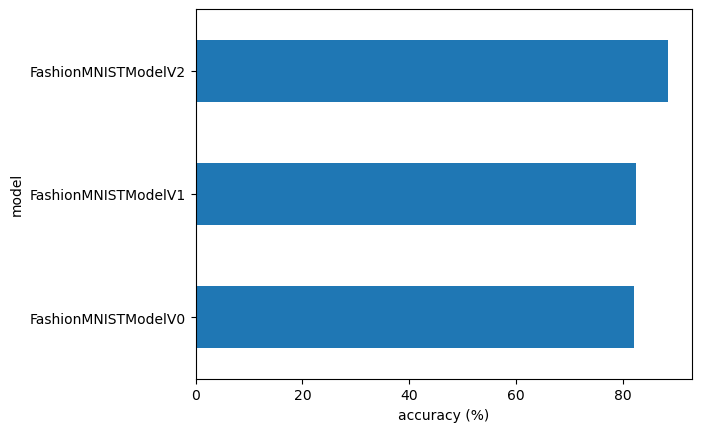

In [49]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# Make and evaluate random predictions with best model

In [87]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Sample is a single image, so you should add the batch size on that image
            sample = torch.unsqueeze(sample,dim=0).to(device) #add a batch dimension and pass to target device


            #forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit --> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)  # use squeeze to get rid of any extra dimension

            '''Use softmax(dim = 0) as we squeeze the data before, which surely removes the extra single dimension from the dataset
            the best practice will be softmax(dim=1) and then squeeze the dataset, which will remove any confusion'''
            # get pred_prob off the GPU for further calculation
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [85]:
import random
random.seed(420)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    
    test_samples.append(sample)
    test_labels.append(label)


#view the first sample image
test_samples[0]
    

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.2784, 0.5216, 0.1059, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1255, 0.5216, 0.1961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314, 0.2784,
          0.2863, 0.3059, 0.7412, 0.6824, 0.6392, 0.6902, 0.6824, 0.6314,
          0.9059, 0.5647, 0.2392, 0.3216, 0.1882, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2784, 0.3098,
          0.2118, 0.1725, 0.1882, 0.4078, 0.5098, 0.8627, 0.7294, 0.4314,
          0.3059, 0.1765, 0.1961, 0.1725, 0.3804, 0.1412, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0902, 0.4314, 0.2667,
          0.2118, 0.2157, 0.1569, 0.2392, 0.3059, 0.3216, 0.2980, 0.2667,
          0.2235, 0.1843, 0.1765, 0.2275, 0.2235, 0.3333,

Text(0.5, 1.0, 'Pullover')

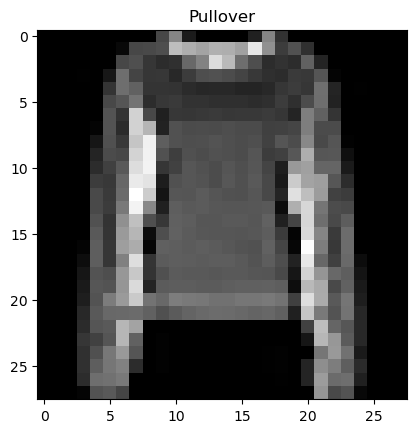

In [86]:
plt.imshow(test_samples[0].squeeze(),cmap = "gray")
plt.title(class_names[test_labels[0]])

In [60]:
test_samples[0].shape

torch.Size([1, 28, 28])

In [53]:
type(test_samples)

list

In [88]:
# Make Predictions

pred_probs = make_predictions(model = model_02,
                              data = test_samples)


In [95]:
pred_probs[0],pred_probs[0].shape

(tensor([6.6372e-04, 1.7537e-04, 9.6721e-01, 1.1878e-04, 1.1944e-02, 6.8336e-06,
         1.9812e-02, 5.3379e-06, 5.4340e-05, 5.2765e-06]),
 torch.Size([10]))

In [90]:
# Convert prediction probabilities into labels
pred_classes = pred_probs.argmax(dim =1)
pred_classes

tensor([2, 3, 5, 5, 8, 5, 5, 0, 3])

In [91]:
test_labels

[2, 3, 5, 5, 8, 5, 9, 0, 3]

In [63]:
len(test_samples)

9

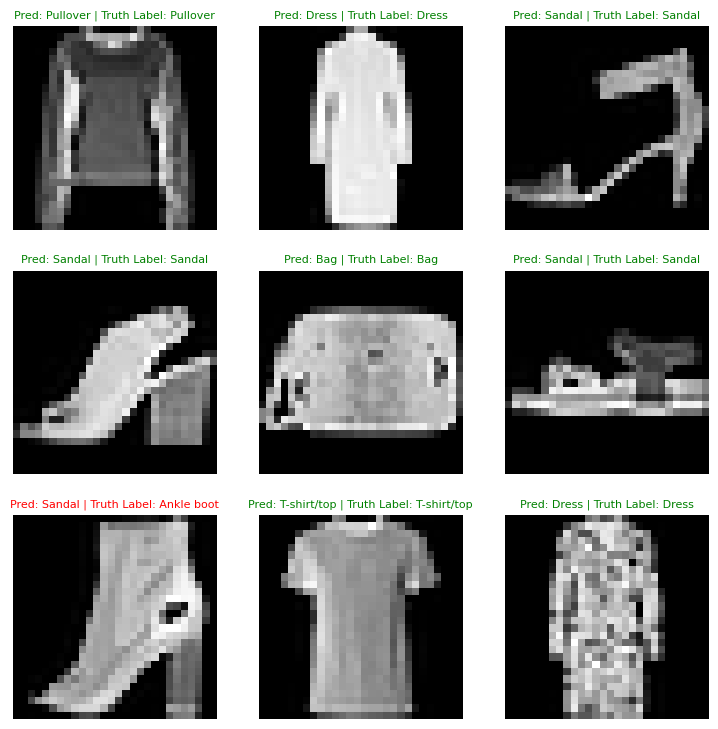

In [92]:
# prediction 
plt.figure(figsize = (9,9))
nrows = 3
ncols = 3

for idx,sample in enumerate(test_samples):

    # create subplot
    plt.subplot(nrows,ncols,idx+1)

    # Plot the sample image
    plt.imshow(sample.squeeze(),cmap = "gray")

    # Find the prediction
    pred_label = class_names[pred_classes[idx]]

    # Get the actual label
    truth_label = class_names[test_labels[idx]]

    title_text = f"Pred: {pred_label} | Truth Label: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text,fontsize = 8,c='g')
    else:
        plt.title(title_text,fontsize = 8,c='r')
    plt.axis(False)


In [80]:
len(test_samples)

9

# Making a confusion matrix for further prediction evaluation

A confusion matrix is another way of evaluation classifying matrix visually

1. Make predictions with our trained model on the test dataset

2. Make a confusion matrix `torch.ConfusionMatrix`

3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`
   

In [111]:
import tqdm 
from tqdm.auto import tqdm

# 1. Make predictions with trained model

# Have to store the predictions in a list
y_preds =[]
model_02.eval()

with torch.inference_mode():
    
    # Extract the image and label
    for X, y in tqdm(test_dataloader, desc="Making Predictions......"):

        # Send the data and targets to target device
        X,y = X.to(device),y.to(device)
        

        # Forward Pass
        y_logit = model_02(X)

        # Turn  predictions from logits --> prediction probabilities --> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(),dim =1).argmax(dim =1)

        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())


    
    print(len(y_preds))
    print(y_preds)
    
    y_pred_tensor = torch.cat(y_preds)
    print(y_pred_tensor)


Making Predictions......:   0%|          | 0/313 [00:00<?, ?it/s]

313
[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 0, 9, 4, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 0, 7, 6, 7, 2, 1, 4, 6, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 1, 3, 3, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 8]), tensor([0, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 2, 4,
        1, 4, 5, 0, 4, 7, 9, 3]), tensor([7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 6, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6,
        7, 9, 9, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 4, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 2, 5, 4, 9, 2, 2, 8, 6, 4,
        6, 4, 9, 7, 6, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 4, 3, 0, 8, 3, 7, 4,
   

In [115]:
!pip install q torchmetrics
!pip install q mlxtend

  Obtaining dependency information for q from https://files.pythonhosted.org/packages/75/f0/ae942c0530d02092702211fd36d9a465e203f732789c84d0b96fbebe3039/q-2.7-py2.py3-none-any.whl.metadata
  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/4c/43/2fc7f76c8891aef148901f1ba3dee65c1cbac00a85ae5ee0dabc2b861256/mlxtend-0.23.4-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.3.1 from https://files.pythonhosted.org/packages/25/92/ee1d7a00bb6b8c55755d4984fd82608603a3cc59959245068ce32e7fb808/scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 240.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 230.8 kB/s eta 

In [117]:
import torchmetrics
import mlxtend

In [119]:
torchmetrics.__version__,mlxtend.__version__


('1.7.0', '0.23.4')

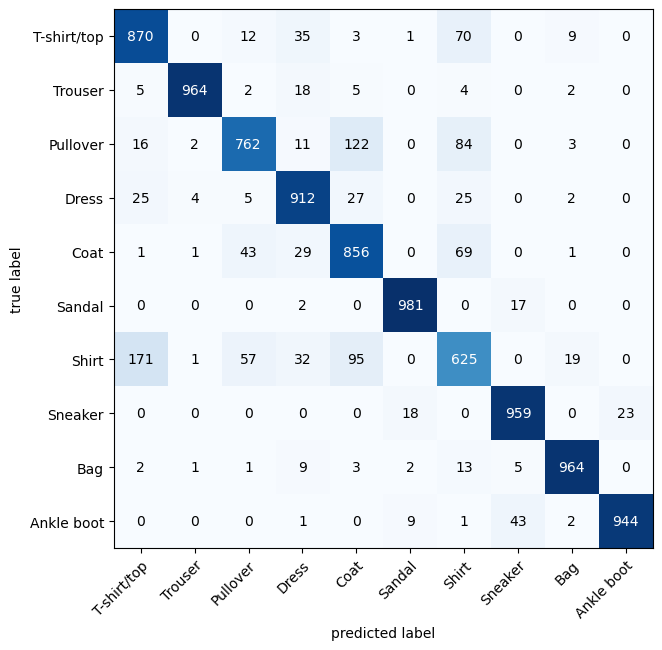

In [124]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare prediction with targets
confmat = ConfusionMatrix(task ='multiclass',
                          num_classes = len(class_names))
confmat_tensor = confmat(preds= y_pred_tensor,
                        target = test_data.targets)


# 3. Plot the confusion matrix
fig,ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    # matplotlib works with numpy
    class_names = class_names,
    figsize = (10,7)
)
  

In [123]:
confmat_tensor

tensor([[870,   0,  12,  35,   3,   1,  70,   0,   9,   0],
        [  5, 964,   2,  18,   5,   0,   4,   0,   2,   0],
        [ 16,   2, 762,  11, 122,   0,  84,   0,   3,   0],
        [ 25,   4,   5, 912,  27,   0,  25,   0,   2,   0],
        [  1,   1,  43,  29, 856,   0,  69,   0,   1,   0],
        [  0,   0,   0,   2,   0, 981,   0,  17,   0,   0],
        [171,   1,  57,  32,  95,   0, 625,   0,  19,   0],
        [  0,   0,   0,   0,   0,  18,   0, 959,   0,  23],
        [  2,   1,   1,   9,   3,   2,  13,   5, 964,   0],
        [  0,   0,   0,   1,   0,   9,   1,  43,   2, 944]])

## Save and Load Best Performing Model

In [126]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path('Models')
MODEL_PATH.mkdir(parents = True,
                exist_ok = True)

# Create model save
MODEL_NAME = "PyTorch_Computer_vision_model_02.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# Save the model state_dict
print(f" Saving the model parameters to {MODEL_SAVE_PATH}")
torch.save(obj = model_02.state_dict(),
          f = MODEL_SAVE_PATH)

 Saving the model parameters to Models/PyTorch_Computer_vision_model_02.pth


In [129]:
FashionMNISTModelV2

__main__.FashionMNISTModelV2

In [130]:
# Create a new instance
torch.manual_seed(42)


loaded_model_2 = FashionMNISTModelV2(input_shape =1,
                                     hidden_units=10,
                                     output_shape=len(class_names))



# Load in the save state dict ()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to target device
loaded_model_2.to(device)

/var/folders/y2/33vgfdz176b018l37jlk7z3m0000gn/T/ipykernel_61192/2406397343.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=

FashionMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [131]:
model_02_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3240518569946289,
 'model_acc': 88.38857827476038}

In [132]:
# Evaluate Loaded Model
torch.manual_seed(42)

loaded_model_2_results = eval_mode(
    model = loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn = accuracy_fn
)


  0%|          | 0/313 [00:00<?, ?it/s]

In [133]:
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3240518569946289,
 'model_acc': 88.38857827476038}

In [135]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_02_results['model_loss']),
             torch.tensor(loaded_model_2_results['model_loss']),
             atol = 1e-02).item() #atol --> tolerance level, upto two decimal points the number should be same


True